Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Import Libraries TA-lib

In [ ]:
!git clone https://github.com/mrjbq7/ta-lib.git

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz

In [ ]:
import os
os.chdir('ta-lib') # Can't use !cd in co-lab

In [ ]:
!./configure --prefix=/usr
!make
!make install

In [ ]:
os.chdir('../')

In [ ]:
!pip install Ta-Lib

In [ ]:
import talib

Get Data

ADRO (PT. Adaro Energy Tbk)

INCO (PT. Vale Indonesia Tbk)

ASII (PT. Astra International Tbk)

IMAS (PT. Indomobil Sukses Internasional Tbk)

TLKM (PT.Telekomunikasi Indonesia (Persero) Tbk)

GIAA (PT. Garuda Indonesia (Persero) Tbk)

In [ ]:
Perusahaan = 'GIAA' #masukkan kode saham
#---------------------------------------
locate = '/content/drive/My Drive/DataIDX per Perusahaan/'+ Perusahaan +'.csv'
df = pd.read_csv( locate,infer_datetime_format=True)

Data Cleaning
-Fitur Selection

In [ ]:
df.drop(['Unnamed: 0',
         'Kode Saham',
         'Nama Perusahaan',
         'Last Trading Date',
         'Selisih',
         'Nilai',
         'Frekuensi',
         'Index Individual',
         'Listed Shares',
         'Offer',
         'Offer Volume',
         'Bid',
         'Bid Volume',
         'Last Trading Date',
         'Tradeble Shares',
         'Weight for Index',
         'Foreign Sell',
         'Foreign Buy',
         'Non Regular Volume',
         'Non Regular Value',
         'Non Regular Frequency',
         #'Sebelumnya',
         'Open Price',
         'First Trade'],
         axis=1, inplace=True)

In [ ]:
# Proses ini berfungsi untuk mengurutkan data menurut waktu atau time series

#ubah tanggal jadi index
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%Y/%m/%d')
df = df.sort_values(by='Tanggal')
df = df.set_index('Tanggal')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1211 entries, 2015-01-05 to 2019-12-30
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sebelumnya  1211 non-null   float64
 1   Tertinggi   1211 non-null   float64
 2   Terendah    1211 non-null   float64
 3   Penutupan   1211 non-null   float64
 4   Volume      1211 non-null   float64
dtypes: float64(5)
memory usage: 56.8 KB


Praprosesing TA

In [ ]:
SMA10 = talib.SMA(df.Penutupan, timeperiod=10) # Simple Moving Average 10 day
WMA10 = talib.WMA(df.Penutupan, timeperiod=10) # Weighted Moving Average 10 days
M = talib.MOM(df.Penutupan, timeperiod=10)     # Momentum
fastk, fastd = talib.STOCHF(df.Tertinggi,      # Stochastic K% dan Stochastic D%
                            df.Terendah, 
                            df.Penutupan, 
                            fastk_period=5, 
                            fastd_period=3)
RSI = talib.RSI(df.Penutupan, timeperiod=14)  # Relative Strength Index (RSI)
macd, macdsignal, macdhist = talib.MACD(      # MACD
                              df.Penutupan, 
                              fastperiod=12, 
                              slowperiod=26, 
                              signalperiod=9)
R = talib.WILLR(df.Tertinggi, df.Terendah,    # Larry William’s R%
                df.Penutupan, timeperiod=14)
AD = talib.ADOSC(df.Tertinggi, df.Terendah,   # Accumulation / Distribution(A/D) Oscillator
                 df.Penutupan, df.Volume, 
                 fastperiod=3, slowperiod=10)
CCI = talib.CCI(df.Tertinggi, df.Terendah,    # CCI
                df.Penutupan, timeperiod=14)

In [ ]:
 # Penggabungan nilai2 TA
 TA = {
     'SMA10' : SMA10,
     'WMA10' : WMA10,
     'Momentum' : M,
     'K%' : fastk,
     'D%' : fastd,
     'RSI' : RSI,
     'MACD' : macd,
     'WillR%' : R,
     'A/DOscillator' : AD,
     'CCI' : CCI
 }
 DfTA = pd.DataFrame(TA)
 DfTA.head(1)

,SMA10,WMA10,Momentum,K%,D%,RSI,MACD,WillR%,A/DOscillator,CCI
Tanggal,,,,,,,,,,
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#drop nan value
DfTA.dropna(inplace=True)
DfTA.tail(1)

,SMA10,WMA10,Momentum,K%,D%,RSI,MACD,WillR%,A/DOscillator,CCI
Tanggal,,,,,,,,,,
2019-12-30,500.2,499.818182,-2.0,14.285714,19.047619,42.648532,-10.621636,-65.853659,-1.822663e+07,-101.561065


## **LABELING -------**

*Fungsi Sliding Window*

In [ ]:
#fungsi membuat fitur jadi mempunyai time step (SLIDING WINDOWS)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Sliding Window + Labeling

In [ ]:
# inputkan panjang label pada variabel Label
# 1  = 1 hari
# 3  = 3 hari
# 7  = 1 minggu
# 14 = 2 minggu
# 30 = 1 bulan
Label = 30

df_reframed_label = series_to_supervised(df,33,Label) 
df_reframed_label.head()
#var1 = open
#var2 = tertinggi
#var3 = terendah
#var4 = penutupan

,var1(t-33),var2(t-33),var3(t-33),var4(t-33),var5(t-33),var1(t-32),var2(t-32),var3(t-32),var4(t-32),var5(t-32),var1(t-31),var2(t-31),var3(t-31),var4(t-31),var5(t-31),var1(t-30),var2(t-30),var3(t-30),var4(t-30),var5(t-30),var1(t-29),var2(t-29),var3(t-29),var4(t-29),var5(t-29),var1(t-28),var2(t-28),var3(t-28),var4(t-28),var5(t-28),var1(t-27),var2(t-27),var3(t-27),var4(t-27),var5(t-27),var1(t-26),var2(t-26),var3(t-26),var4(t-26),var5(t-26),...,var1(t+22),var2(t+22),var3(t+22),var4(t+22),var5(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var1(t+24),var2(t+24),var3(t+24),var4(t+24),var5(t+24),var1(t+25),var2(t+25),var3(t+25),var4(t+25),var5(t+25),var1(t+26),var2(t+26),var3(t+26),var4(t+26),var5(t+26),var1(t+27),var2(t+27),var3(t+27),var4(t+27),var5(t+27),var1(t+28),var2(t+28),var3(t+28),var4(t+28),var5(t+28),var1(t+29),var2(t+29),var3(t+29),var4(t+29),var5(t+29)
Tanggal,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-02-23,565.0,620.0,550.0,610.0,23001000.0,610.0,635.0,600.0,635.0,52069000.0,635.0,650.0,620.0,620.0,26374200.0,620.0,630.0,610.0,620.0,5983000.0,620.0,625.0,600.0,600.0,8547900.0,600.0,630.0,600.0,620.0,13103600.0,620.0,625.0,610.0,615.0,5506500.0,615.0,620.0,605.0,610.0,9267100.0,...,492.0,497.0,476.0,486.0,11342700.0,486.0,489.0,479.0,483.0,4381200.0,483.0,489.0,480.0,485.0,4236100.0,485.0,499.0,485.0,496.0,6388500.0,496.0,505.0,488.0,492.0,5642200.0,492.0,497.0,485.0,495.0,3314700.0,495.0,498.0,488.0,488.0,1982600.0,488.0,495.0,488.0,491.0,2027700.0
2015-02-24,610.0,635.0,600.0,635.0,52069000.0,635.0,650.0,620.0,620.0,26374200.0,620.0,630.0,610.0,620.0,5983000.0,620.0,625.0,600.0,600.0,8547900.0,600.0,630.0,600.0,620.0,13103600.0,620.0,625.0,610.0,615.0,5506500.0,615.0,620.0,605.0,610.0,9267100.0,610.0,615.0,595.0,605.0,18395800.0,...,486.0,489.0,479.0,483.0,4381200.0,483.0,489.0,480.0,485.0,4236100.0,485.0,499.0,485.0,496.0,6388500.0,496.0,505.0,488.0,492.0,5642200.0,492.0,497.0,485.0,495.0,3314700.0,495.0,498.0,488.0,488.0,1982600.0,488.0,495.0,488.0,491.0,2027700.0,491.0,497.0,490.0,496.0,2142800.0
2015-02-25,635.0,650.0,620.0,620.0,26374200.0,620.0,630.0,610.0,620.0,5983000.0,620.0,625.0,600.0,600.0,8547900.0,600.0,630.0,600.0,620.0,13103600.0,620.0,625.0,610.0,615.0,5506500.0,615.0,620.0,605.0,610.0,9267100.0,610.0,615.0,595.0,605.0,18395800.0,600.0,605.0,580.0,590.0,5970900.0,...,483.0,489.0,480.0,485.0,4236100.0,485.0,499.0,485.0,496.0,6388500.0,496.0,505.0,488.0,492.0,5642200.0,492.0,497.0,485.0,495.0,3314700.0,495.0,498.0,488.0,488.0,1982600.0,488.0,495.0,488.0,491.0,2027700.0,491.0,497.0,490.0,496.0,2142800.0,496.0,500.0,485.0,489.0,4472600.0
2015-02-26,620.0,630.0,610.0,620.0,5983000.0,620.0,625.0,600.0,600.0,8547900.0,600.0,630.0,600.0,620.0,13103600.0,620.0,625.0,610.0,615.0,5506500.0,615.0,620.0,605.0,610.0,9267100.0,610.0,615.0,595.0,605.0,18395800.0,600.0,605.0,580.0,590.0,5970900.0,590.0,590.0,565.0,580.0,5378300.0,...,485.0,499.0,485.0,496.0,6388500.0,496.0,505.0,488.0,492.0,5642200.0,492.0,497.0,485.0,495.0,3314700.0,495.0,498.0,488.0,488.0,1982600.0,488.0,495.0,488.0,491.0,2027700.0,491.0,497.0,490.0,496.0,2142800.0,496.0,500.0,485.0,489.0,4472600.0,489.0,545.0,486.0,540.0,41493300.0
2015-02-27,620.0,625.0,600.0,600.0,8547900.0,600.0,630.0,600.0,620.0,13103600.0,620.0,625.0,610.0,615.0,5506500.0,615.0,620.0,605.0,610.0,9267100.0,610.0,615.0,595.0,605.0,18395800.0,600.0,605.0,580.0,590.0,5970900.0,590.0,590.0,565.0,580.0,5378300.0,580.0,600.0,580.0,585.0,8847300.0,...,496.0,505.0,488.0,492.0,5642200.0,492.0,497.0,485.0,495.0,3314700.0,495.0,498.0,488.0,488.0,1982600.0,488.0,495.0,488.0,491.0,2027700.0,491.0,497.0,490.0,496.0,2142800.0,496.0,500.0,485.0,489.0,4472600.0,489.0,545.0,486.0,540.0,41493300.0,540.0,580.0,535.0,565.0,34806500.0


Labeling

In [ ]:
#kolom selain label di time step t remove
df_reframed_label.drop(df_reframed_label.iloc[ : , :-2 ], axis=1, inplace=True)
df_reframed_label.drop(df_reframed_label.iloc[ : , -1: ], axis=1, inplace=True)
# ini adalah label dataset
df_reframed_label.head()                                                       

,var4(t+29)
Tanggal,
2015-02-23,491.0
2015-02-24,496.0
2015-02-25,489.0
2015-02-26,540.0
2015-02-27,565.0


In [ ]:
if Label == 3: DfTA.drop(DfTA.index[-2:], axis=0, inplace=True)
if Label == 7: DfTA.drop(DfTA.index[-6:], axis=0, inplace=True) 
if Label == 14: DfTA.drop(DfTA.index[-13:], axis=0, inplace=True) 
if Label == 30: DfTA.drop(DfTA.index[-29:], axis=0, inplace=True) 

## **LABELING END---------**

Min Max Scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
v = DfTA.values
df_normalized = scaler.fit_transform(v)
df_normalized

array([[0.84817814, 0.85059438, 0.39202658, ..., 0.41176471, 0.40118825,
        0.37594505],
       [0.84691296, 0.84966927, 0.42524917, ..., 0.38461538, 0.38759142,
        0.34547898],
       [0.84817814, 0.85128822, 0.45847176, ..., 0.46153846, 0.38435585,
        0.34272734],
       ...,
       [0.96077935, 0.95351311, 0.39202658, ..., 0.35294118, 0.38273777,
        0.24414974],
       [0.95192308, 0.94125538, 0.3255814 , ..., 0.11764706, 0.37347793,
        0.22143122],
       [0.94812753, 0.94449327, 0.39202658, ..., 0.47058824, 0.38911815,
        0.28688717]])

In [ ]:
#normalisasi label
w = df_reframed_label.values
df_normalized_label = scaler.fit_transform(w)
df_normalized_label

array([[0.67674419],
       [0.68837209],
       [0.67209302],
       ...,
       [0.69767442],
       [0.69302326],
       [0.69302326]])

In [ ]:
#reshape label
vl = df_normalized_label
label = vl.reshape((vl.shape[0]))

Split Training , Validation, Testing Data

In [ ]:
from sklearn.model_selection import train_test_split
X = df_normalized       #dataset
Y = df_normalized_label #label
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)
X_validation, X_Test, Y_validation, Y_Test = train_test_split(X_test, Y_test, test_size=0.66, shuffle=False)

In [ ]:
#reshape jadi 3D
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_Test = X_Test.reshape((X_Test.shape[0], 1, X_Test.shape[1]))
X_validation = X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))
print(X_train.shape, Y_train.shape, X_Test.shape, Y_Test.shape, X_validation.shape, Y_validation.shape) 

(804, 1, 10) (804, 1) (228, 1, 10) (228, 1) (117, 1, 10) (117, 1)


Pembentukan Arsitektur RNN-GRU

In [ ]:
unit1 = 50 #inisiasi banyak unit
unit2 = 200
DO1 = 0.5 #inisiasi Dropout 
DO2 = 0.2

model = tf.keras.models.Sequential([                                  
  tf.keras.layers.GRU(unit1, return_sequences=True),
  #tf.keras.layers.Dropout(DO1),
  tf.keras.layers.GRU(unit2, return_sequences=True),
  #tf.keras.layers.Dropout(DO2),
  tf.keras.layers.Dense(1, activation="sigmoid") #inisialisasi output layer
])

In [ ]:
# Disini Penyimpan Model Terbaik diinisialisasi

#callback
#from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
#es = EarlyStopping(monitor='val_loss', mode='min', patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True) #H5

Inisialisasi parameter GRU

In [ ]:
#inisialisasi parameter RNN-GRU
optimizer = tf.keras.optimizers.Adam() # inisialisasi optimizer gradient descent
model.compile(
              loss=tf.keras.losses.MAE, # inisialisasi loss function
              optimizer=optimizer,
              metrics=["mae"])          # inisialisasi metode pengujian (MAE dan RMSE)

Training

In [ ]:
Epoch = 300 # inisialisasi epoch

history = model.fit(X_train, 
                    Y_train, 
                    epochs=Epoch, 
                    validation_data=(X_validation, Y_validation), 
                    verbose=2,
                    batch_size = 252, # inisiasi batch
                    callbacks=[mc])

Epoch 1/300
4/4 - 5s - loss: 0.1799 - mae: 0.1799 - val_loss: 0.3937 - val_mae: 0.3937

Epoch 00001: val_mae improved from inf to 0.39369, saving model to best_model.h5
Epoch 2/300
4/4 - 0s - loss: 0.1681 - mae: 0.1681 - val_loss: 0.3580 - val_mae: 0.3580

Epoch 00002: val_mae improved from 0.39369 to 0.35802, saving model to best_model.h5
Epoch 3/300
4/4 - 0s - loss: 0.1564 - mae: 0.1564 - val_loss: 0.3161 - val_mae: 0.3161

Epoch 00003: val_mae improved from 0.35802 to 0.31609, saving model to best_model.h5
Epoch 4/300
4/4 - 0s - loss: 0.1504 - mae: 0.1504 - val_loss: 0.2796 - val_mae: 0.2796

Epoch 00004: val_mae improved from 0.31609 to 0.27955, saving model to best_model.h5
Epoch 5/300
4/4 - 0s - loss: 0.1486 - mae: 0.1486 - val_loss: 0.2713 - val_mae: 0.2713

Epoch 00005: val_mae improved from 0.27955 to 0.27126, saving model to best_model.h5
Epoch 6/300
4/4 - 0s - loss: 0.1451 - mae: 0.1451 - val_loss: 0.2782 - val_mae: 0.2782

Epoch 00006: val_mae did not improve from 0.27126
E

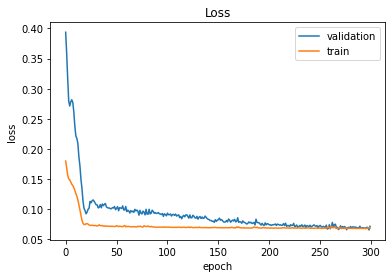

In [ ]:
#tampilkan performa pada saat pelatihan
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation','train'], loc='upper right')
plt.show()

Uji dengan Model terbaik

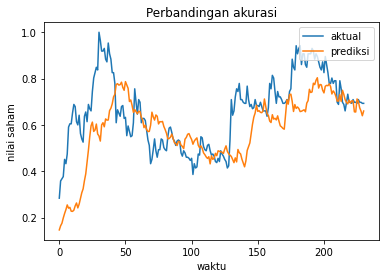

In [ ]:
from keras.models import load_model

#Load Best Model
model.save('best_model.h5')
Best_Model = load_model('best_model.h5')

#lakukan prediksi
prediksi = Best_Model.predict(X_Test)
Prediksi = prediksi.reshape((prediksi.shape[0]))

# Tampilkan perbandingan akurasi
plt.plot(Y_Test)
plt.plot(Prediksi)
plt.title('Perbandingan akurasi')
plt.ylabel('nilai saham')
plt.xlabel('waktu')
plt.legend(['aktual', 'prediksi'], loc='upper right')
plt.show()

Denormalisasi

In [ ]:
# Get data label Testing dengan urut waktu
rentang_label = 0
if Label == 1: rentang_label = 944
if Label == 3: rentang_label = 943
if Label == 7: rentang_label = 939
if Label == 14: rentang_label = 934
if Label == 30: rentang_label = 921

kolom_label = "kosong"
if Label == 1: kolom_label = "var4(t)"
if Label == 3: kolom_label = "var4(t+2)"
if Label == 7: kolom_label = "var4(t+6)"
if Label == 14: kolom_label = "var4(t+13)"
if Label == 30: kolom_label = "var4(t+29)"

int_aktual = []
for x in df_reframed_label.iloc[ rentang_label: , 0]:
  int_aktual.append(round(x))


DF_aktual = pd.DataFrame(df_reframed_label.iloc[ rentang_label: , 0]) 
DF_aktual = DF_aktual.rename({kolom_label:"Aktual"}, axis=1)
DF_aktual['Aktual'] = int_aktual
DF_aktual.tail()

,Aktual
Tanggal,
2019-11-11,505
2019-11-12,500
2019-11-13,500
2019-11-14,498
2019-11-15,498


Fungsi Denormalisasi

In [ ]:
# Fungsi mencari nilai Max()
def myMax(x):
  panjang = len(x)
  Vmax = 0 
  for i in x:
    if i > Vmax:
      Vmax = i
  
  return Vmax

# Fungsi mencari nilai Min()
def myMin(x):
  panjang = len(x)
  Vmin = 10000000000000 
  for i in x:
    if i < Vmin:
      Vmin = i
  
  return Vmin

# Fungsi Denormalisasi
def denormalize(x, min, max):
    final_value = x*(max - min) + min
    return round(final_value)

In [ ]:
# Cari Nilai Max() & Min()
min = myMin(df_reframed_label[kolom_label])
max = myMax(df_reframed_label[kolom_label])

# DENORMALISASI
denormalize_Prediksi = []
for y in Prediksi:
   denormalize_Prediksi.append(denormalize(y,min,max))

# buat data Pengujian
DF_aktual['Prediksi'] = denormalize_Prediksi
DF_Testing = DF_aktual
DF_Testing.head() 

,Aktual,Prediksi
Tanggal,,
2018-12-11,362,264
2018-12-12,394,262
2018-12-13,386,268
2018-12-14,404,265
2018-12-17,454,269


PENGUJIAN

Inisiasi Fungsi Pengujian

In [ ]:
from math import sqrt
# MAE
def MAE(y_prediksi, y_aktual):
  sum = 0
  for i in range(len(y_prediksi)):
    sum = sum + abs(y_aktual[i]-y_prediksi[i])
  return (sum/len(y_prediksi))

# RMSE  
def RMSE(y_prediksi, y_aktual):
  sum = 0
  for i in range(len(y_prediksi)):
    sum = sum + (y_aktual[i]-y_prediksi[i])**2
  return sqrt(sum/len(y_prediksi))

# DA
def DA(y_prediksi, y_aktual):
  sum = 0
  for i in range(len(y_prediksi)-1):
    value = (y_aktual[i+1]-y_aktual[i])*(y_prediksi[i+1]-y_prediksi[i])
    if value >= 0 :
      sum = sum + 1
  hasil = (sum/(len(y_prediksi)-1))*100
  return hasil

# MAPE
def MAPE(y_prediksi, y_aktual):
  sum = 0
  for i in range(len(y_prediksi)):
    sum = sum + (abs(y_aktual[i] - y_prediksi[i])/y_aktual[i])
  hasil = (sum/len(y_prediksi))*100
  return hasil

In [ ]:
mae = MAE(DF_aktual['Prediksi'],DF_aktual['Aktual'])
rmse = RMSE(DF_aktual['Prediksi'],DF_aktual['Aktual'])
da = DA(DF_aktual['Prediksi'],DF_aktual['Aktual'])
mape = MAPE(DF_aktual['Prediksi'],DF_aktual['Aktual'])
print("MAE  = "+ str(mae))
print("RMSE = "+ str(rmse))
print("DA   = "+ str(da) + " %")
print("MAPE = "+ str(mape) + " %")

MAE  = 79.28947368421052
RMSE = 102.54853365302678
DA   = 58.14977973568281 %
MAPE = 15.719217772226312 %


Presentasi Grafik Detail

In [ ]:
DF_aktual.to_csv("prediksiXaktual.csv")